
# Name : **Shravanthi Balasubramanian**
# School :SCDS
# Email ID : *shravanthi.b-26@scds.saiuniversity.edu.in

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import shutil
import zipfile
import os

zip_path = '/content/drive/MyDrive/Car_Dataset.zip'
extract_path = '/content/Car_Dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

source_dir = '/content/Car_Dataset/Car_Dataset'
train_dir = '/content/splits/train'
test_dir = '/content/splits/test'

if os.path.exists(source_dir):
    print("Source directory exists:", os.listdir(source_dir))
else:
    print("Source directory does not exist:", source_dir)

print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        #all files in curr class directory
        all_files = os.listdir(class_path)

        #train test split
        train_files, test_files = train_test_split(all_files, test_size=0.25, random_state=42)

        for file in train_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(train_dir, class_name, file)
            if not os.path.exists(dst):
                shutil.move(src, dst)

        for file in test_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(test_dir, class_name, file)
            if not os.path.exists(dst):
                shutil.move(src, dst)


Dataset extracted to: /content/Car_Dataset
Source directory exists: ['Toyota Innova', 'Mahindra Scorpio', 'Swift', 'Audi', 'Rolls Royce', 'Tata Safari', 'Hyundai Creta']
Train directory exists: False
Test directory exists: False


In [ ]:
#prep dataset
def prepare_data(source_dir):
    file_paths, labels = [], []
    classes = os.listdir(source_dir)
    for class_name in classes:
        class_folder = os.path.join(source_dir, class_name)
        if os.path.isdir(class_folder):
            for file in os.listdir(class_folder):
                file_paths.append(os.path.join(class_folder, file))
                labels.append(class_name)
    return file_paths, labels, classes

file_paths, labels, classes = prepare_data(source_dir)
num_classes = len(classes)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

#load and preprocess images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)  #rescale for testing

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode= 'categorical',
    shuffle=False
)




Found 2811 images belonging to 7 classes.
Found 309 images belonging to 7 classes.
Found 1045 images belonging to 7 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

train_dir = '/content/splits/train'
save_path = '/content/drive/MyDrive/best_TL_model.keras'
final_model_path = '/content/drive/MyDrive/ResNet101V2_TL_final.keras'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)

#base ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#25% of initial layers to non-trainable, remaining to trainable
total_layers = len(base_model.layers)
non_trainable_layers = int(0.25 * total_layers)

for layer_index, layer in enumerate(base_model.layers):
    if layer_index < non_trainable_layers:
        layer.trainable = False
    else:
        layer.trainable = True

global_pool = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(global_pool)
x = Dropout(0.25)(x)
output_ = Dense(num_classes, activation='softmax')(x)

model_TL = Model(inputs=base_model.input, outputs=output_)

model_TL.compile(loss='categorical_crossentropy',
                 optimizer=Adam(learning_rate=1e-4),
                 metrics=['accuracy'])

callbacks_TL = [
    ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
]

history_TL = model_TL.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks_TL
)

model_TL.save(final_model_path)
print("Fine-tuning complete. Best model saved to:", final_model_path)

Found 2811 images belonging to 7 classes.
Found 309 images belonging to 7 classes.
171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.5315 - loss: 1.4307
Epoch 1: val_accuracy improved from -inf to 0.89644, saving model to /content/drive/MyDrive/best_TL_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 157s 887ms/step - accuracy: 0.5336 - loss: 1.4244 - val_accuracy: 0.8964 - val_loss: 0.3263
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9833 - loss: 0.0744
Epoch 2: val_accuracy improved from 0.89644 to 0.94822, saving model to /content/drive/MyDrive/best_TL_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 59s 380ms/step - accuracy: 0.9833 - loss: 0.0743 - val_accuracy: 0.9482 - val_loss: 0.1667
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9959 - loss: 0.0166
Epoch 3: val_accuracy did not improve from 0.94822
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 351ms/step - accuracy: 0.9959 - loss: 0.0166 - val_accuracy: 0.9450 - val_loss: 0.1468
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9996 - loss: 0.0056
Epoch 4: val_accuracy improved fro

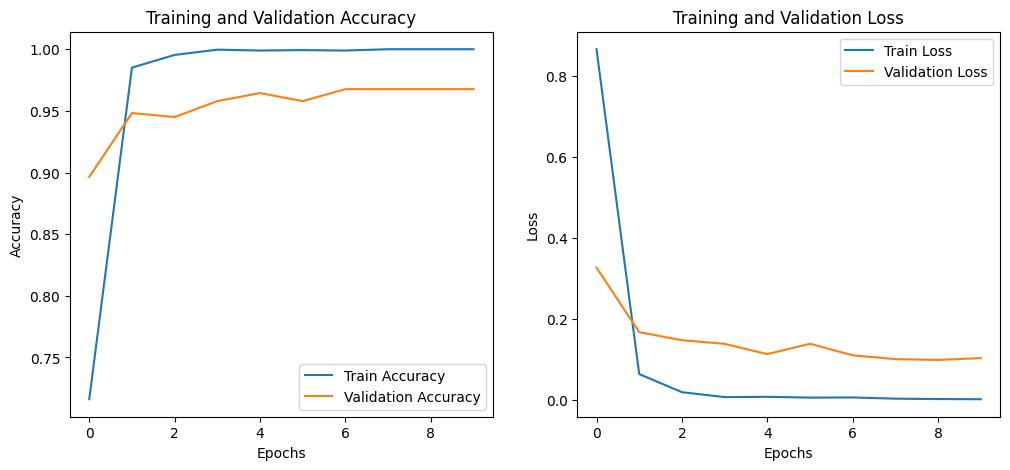

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step


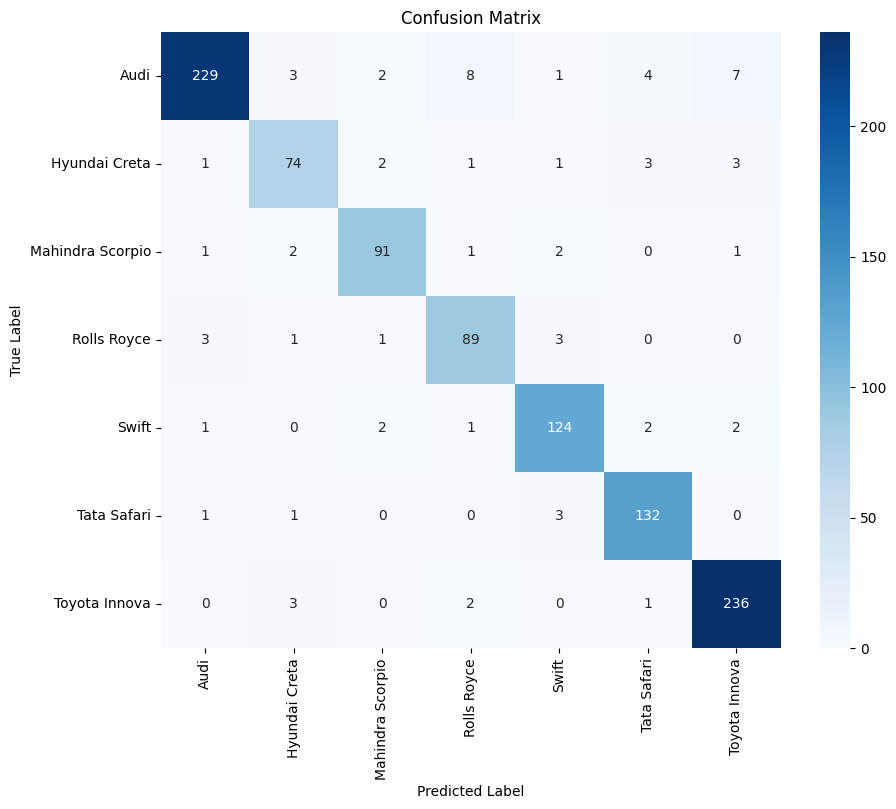

Classification Report:
                  precision    recall  f1-score   support

            Audi       0.97      0.90      0.93       254
   Hyundai Creta       0.88      0.87      0.88        85
Mahindra Scorpio       0.93      0.93      0.93        98
     Rolls Royce       0.87      0.92      0.89        97
           Swift       0.93      0.94      0.93       132
     Tata Safari       0.93      0.96      0.95       137
   Toyota Innova       0.95      0.98      0.96       242

        accuracy                           0.93      1045
       macro avg       0.92      0.93      0.92      1045
    weighted avg       0.93      0.93      0.93      1045



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

def plot_confusion_matrix(model, generator):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes

    conf_mat = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=generator.class_indices.keys(),
                yticklabels=generator.class_indices.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=list(generator.class_indices.keys())))

plot_training_history(history_TL)
plot_confusion_matrix(model_TL, test_generator)
